# Quantile Forecasts

Quantile forecasts are a critical component of TimeGPT's approach to time series forecasting, offering an understanding of future uncertainties. Unlike traditional point forecasts, which provide a singular expected value, quantile forecasts present specific percentiles of the forecast distribution, allowing for a more detailed exploration of potential outcomes.

This method acknowledges the inherent randomness in future time series values by treating them as random variables with their own distribution, termed the "forecast distribution." Quantile forecasts then extract key points from this distribution, each representing a different level of confidence or probability. For instance, the 25th and 75th quantiles give insights into the lower and upper quartiles of expected outcomes, respectively, while the 50th quantile, or median, offers a central estimate.

By focusing on quantile forecasts, TimeGPT enables users to gauge not just a single expected outcome but to assess the likelihood of various scenarios. This approach is helpful for planning under uncertainty, providing a spectrum of possible future values, each attached to a specific confidence level. Thus, users can make more informed decisions by considering the full range of potential outcomes. TimeGPT uses conformal prediction to produce the quantiles.

In [ ]:
#| hide
from nixtla.utils import colab_badge

In [ ]:
#| echo: false
colab_badge('docs/tutorials/10_quantile_forecasts')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/10_quantile_forecasts.ipynb)

In [ ]:
#| hide
from itertools import product

from fastcore.test import test_eq, test_fail, test_warns
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

True

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

In [ ]:
#| hide
nixtla_client = NixtlaClient()

When using TimeGPT for time series forecasting, you can set the quantiles you want to predict. Here's how you could do it:

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
timegpt_quantile_fcst_df = nixtla_client.forecast(
    df=df, h=12, 
    quantiles=quantiles, 
    time_col='timestamp', target_col='value',
)
timegpt_quantile_fcst_df.head()

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: MS
INFO:nixtlats.nixtla_client:Restricting input...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...


,timestamp,TimeGPT,TimeGPT-q-10,TimeGPT-q-20,TimeGPT-q-30,TimeGPT-q-40,TimeGPT-q-50,TimeGPT-q-60,TimeGPT-q-70,TimeGPT-q-80,TimeGPT-q-90
0,1961-01-01,437.837952,431.987091,435.043799,435.384363,436.402155,437.837952,439.273749,440.291541,440.632104,443.688812
1,1961-02-01,426.062744,412.704956,414.832837,416.042432,421.719196,426.062744,430.406293,436.083057,437.292651,439.420532
2,1961-03-01,463.116577,437.412564,444.234985,446.420233,450.705762,463.116577,475.527393,479.812921,481.998169,488.820590
3,1961-04-01,478.244507,448.726837,455.428375,465.570038,469.879114,478.244507,486.609900,490.918976,501.060638,507.762177
4,1961-05-01,505.646484,478.409872,493.154315,497.990848,499.138708,505.646484,512.154260,513.302121,518.138654,532.883096


TimeGPT will return forecasts in the format `TimeGPT-q-{int(100 * q)}` for each quantile `q`.

In [ ]:
#| hide
# test shorter horizon
level_short_horizon_df = nixtla_client.forecast(
    df=df, h=6, quantiles=quantiles, 
    time_col='timestamp', target_col='value',
)
test_eq(
    level_short_horizon_df.shape,
    (6, 2 + len(quantiles))
)

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: MS
INFO:nixtlats.nixtla_client:Restricting input...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...


In [ ]:
#| hide
cols_fcst_df = nixtla_client.forecast(
    df=df, h=12, 
    quantiles=quantiles, 
    time_col='timestamp', target_col='value',
).columns
assert all(f'TimeGPT-q-{int(100 * q)}' in cols_fcst_df for q in quantiles)

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: MS
INFO:nixtlats.nixtla_client:Restricting input...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...


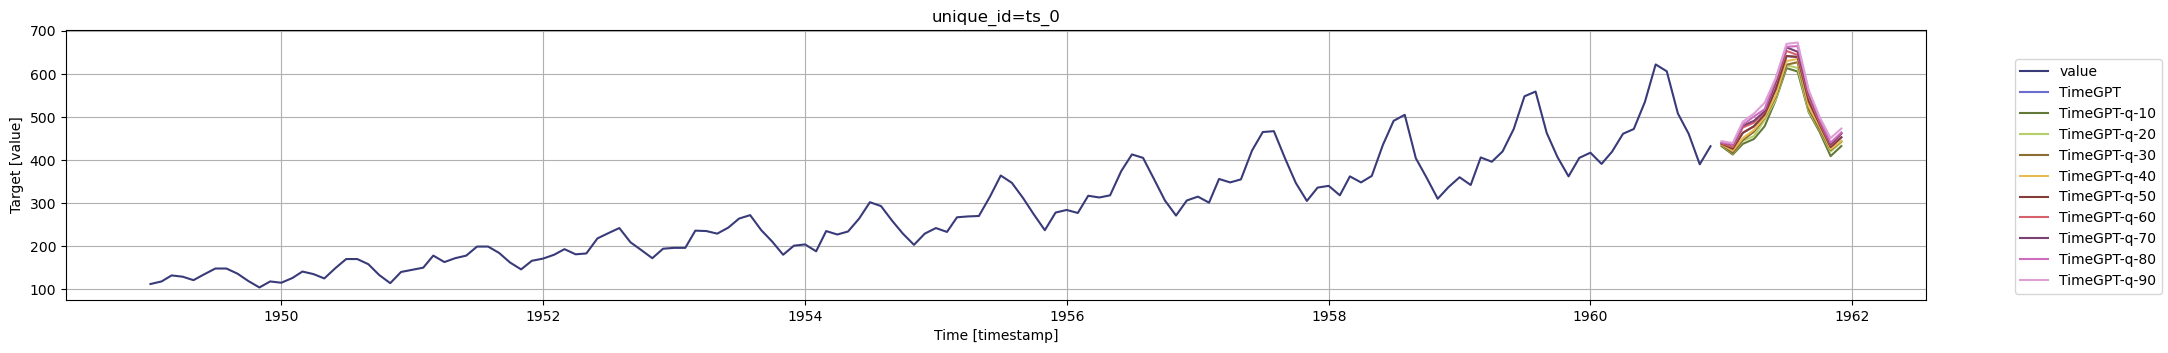

In [ ]:
nixtla_client.plot(
    df, timegpt_quantile_fcst_df, 
    time_col='timestamp', target_col='value',
)

It's essential to note that the choice of the quantile (or quantiles) depends on your specific use case. For high-stakes predictions, you might lean towards more conservative quantiles, such as the 10th or 20th percentile, to ensure you're prepared for worse-case scenarios. On the other hand, if you're in a situation where the cost of over-preparation is high, you might choose a quantile closer to the median, like the 50th percentile, to balance being cautious and efficient.

For instance, if you're managing inventory for a retail business during a big sale event, opting for a lower quantile might help you avoid running out of stock, even if it means you might overstock a bit. But if you're scheduling staff for a restaurant, you might go with a quantile closer to the middle to ensure you have enough staff on hand without significantly overstaffing.

Ultimately, the choice comes down to understanding the balance between risk and cost in your specific context, and using quantile forecasts from TimeGPT allows you to tailor your strategy to fit that balance perfectly.

#### Historical Forecast

You can also compute quantile forecasts for historical forecasts adding the `add_history=True` parameter as follows:

In [ ]:
timegpt_quantile_fcst_df = nixtla_client.forecast(
    df=df, h=12, 
    quantiles=quantiles, 
    time_col='timestamp', target_col='value',
    add_history=True,
)
timegpt_quantile_fcst_df.head()

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: MS
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Calling Historical Forecast Endpoint...


,timestamp,TimeGPT,TimeGPT-q-10,TimeGPT-q-20,TimeGPT-q-30,TimeGPT-q-40,TimeGPT-q-50,TimeGPT-q-60,TimeGPT-q-70,TimeGPT-q-80,TimeGPT-q-90
0,1951-01-01,135.483673,111.937767,120.020593,125.848879,130.828935,135.483673,140.138411,145.118467,150.946753,159.029579
1,1951-02-01,144.442413,120.896508,128.979334,134.807620,139.787675,144.442413,149.097151,154.077207,159.905493,167.988319
2,1951-03-01,157.191910,133.646004,141.728830,147.557116,152.537172,157.191910,161.846648,166.826704,172.654990,180.737815
3,1951-04-01,148.769379,125.223473,133.306299,139.134585,144.114641,148.769379,153.424117,158.404172,164.232458,172.315284
4,1951-05-01,140.472946,116.927041,125.009866,130.838152,135.818208,140.472946,145.127684,150.107740,155.936026,164.018852


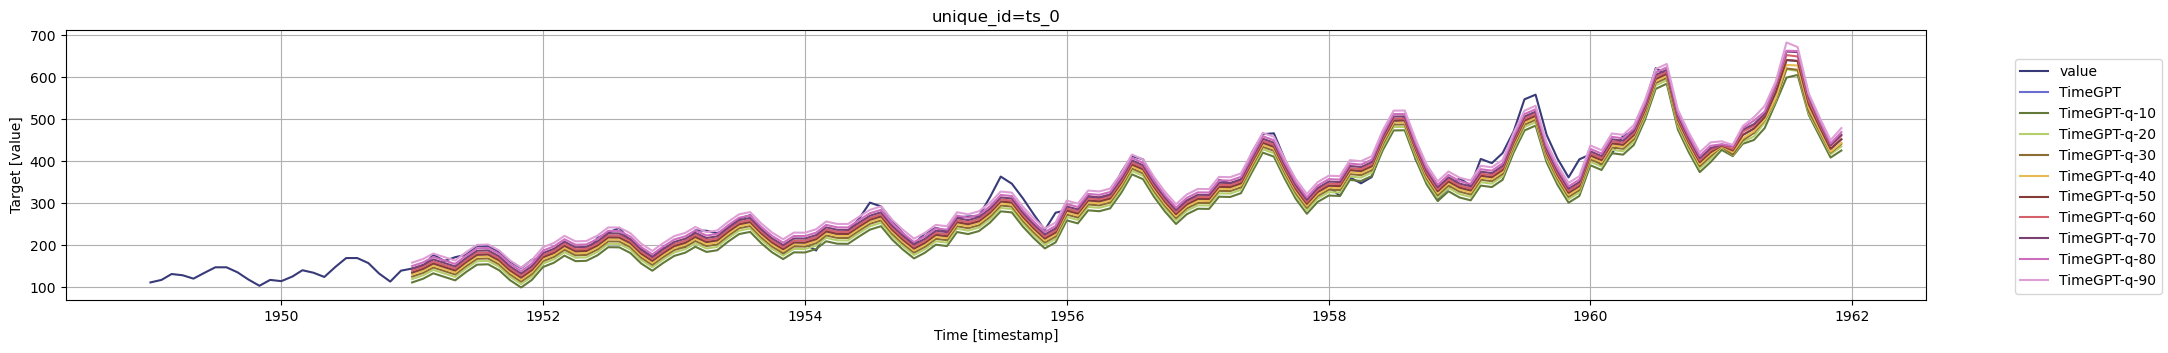

In [ ]:
nixtla_client.plot(
    df, timegpt_quantile_fcst_df, 
    time_col='timestamp', target_col='value',
)

#### Cross Validation

The `quantiles` argument can also be included in the `cross_validation` method, allowing comparing the performance of TimeGPT across different windows and different quantiles.

In [ ]:
timegpt_cv_quantile_fcst_df = nixtla_client.cross_validation(
    df=df, 
    h=12, 
    n_windows=5,
    quantiles=quantiles, 
    time_col='timestamp', 
    target_col='value',
)
timegpt_quantile_fcst_df.head()

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Inferred freq: MS
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: MS
INFO:nixtlats.nixtla_client:Restricting input...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: MS
INFO:nixtlats.nixtla_client:Restricting input...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: MS
INFO:nixtlats.nixtla_client:Restricting input...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validati

,timestamp,TimeGPT,TimeGPT-q-10,TimeGPT-q-20,TimeGPT-q-30,TimeGPT-q-40,TimeGPT-q-50,TimeGPT-q-60,TimeGPT-q-70,TimeGPT-q-80,TimeGPT-q-90
0,1951-01-01,135.483673,111.937767,120.020593,125.848879,130.828935,135.483673,140.138411,145.118467,150.946753,159.029579
1,1951-02-01,144.442413,120.896508,128.979334,134.807620,139.787675,144.442413,149.097151,154.077207,159.905493,167.988319
2,1951-03-01,157.191910,133.646004,141.728830,147.557116,152.537172,157.191910,161.846648,166.826704,172.654990,180.737815
3,1951-04-01,148.769379,125.223473,133.306299,139.134585,144.114641,148.769379,153.424117,158.404172,164.232458,172.315284
4,1951-05-01,140.472946,116.927041,125.009866,130.838152,135.818208,140.472946,145.127684,150.107740,155.936026,164.018852


In [ ]:
from IPython.display import display

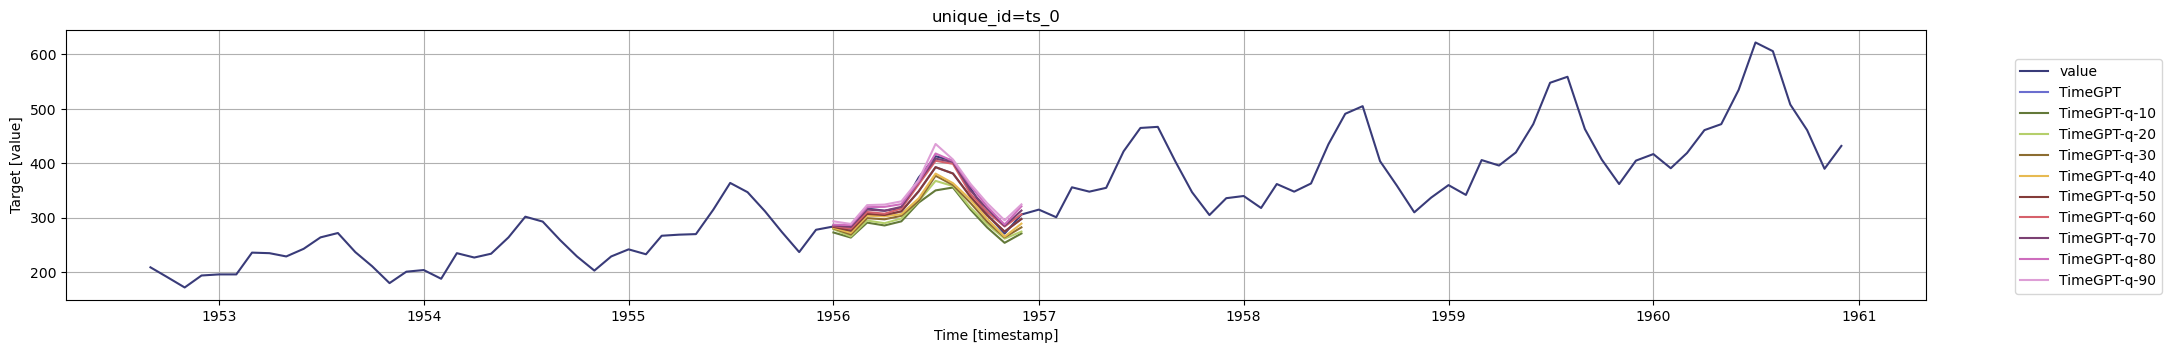

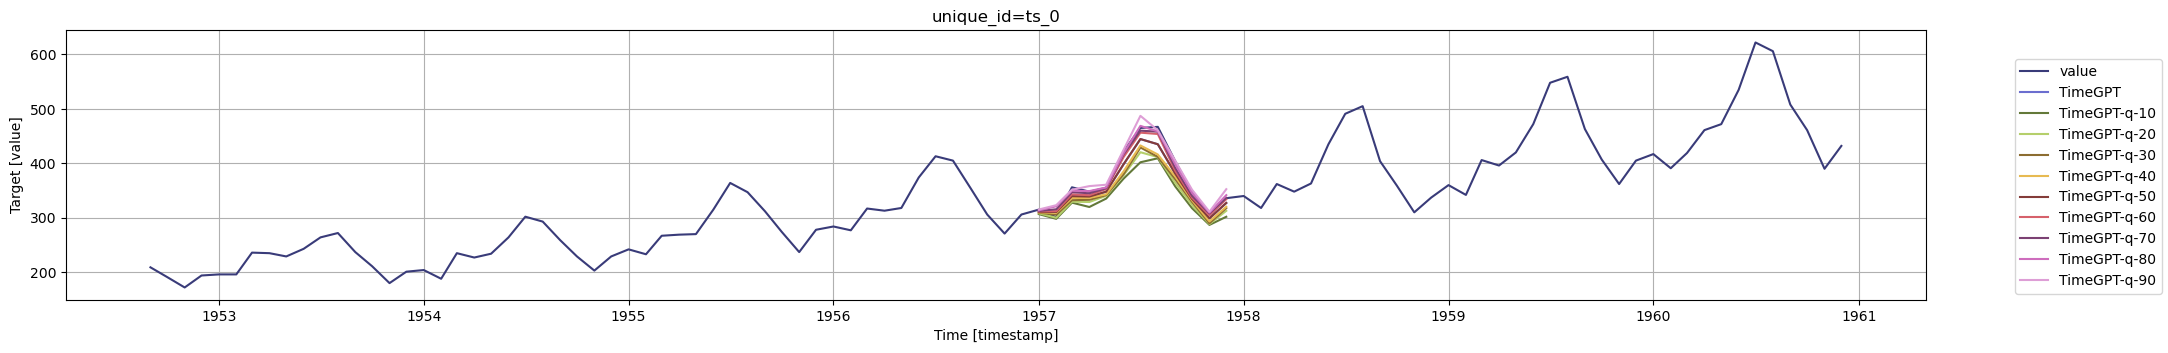

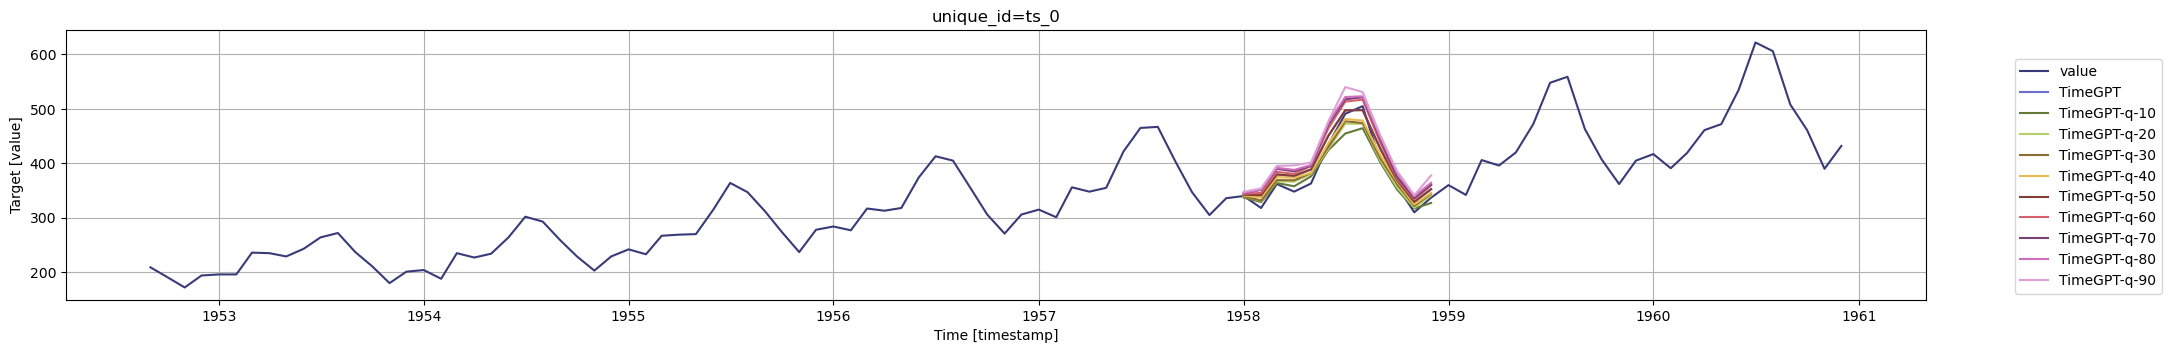

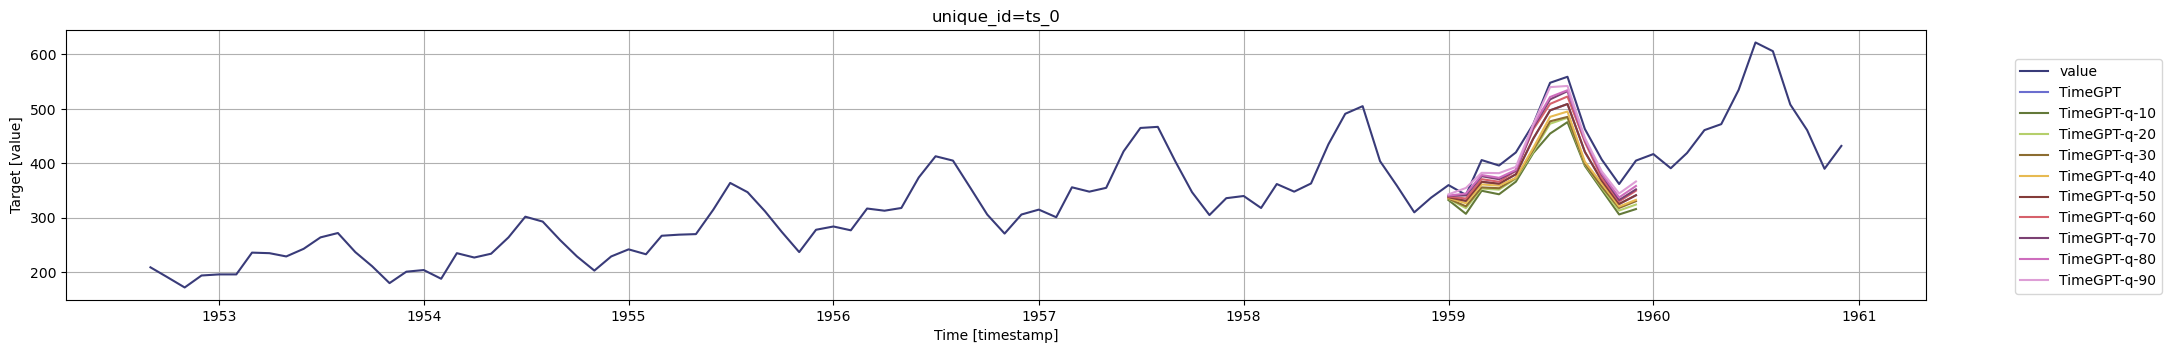

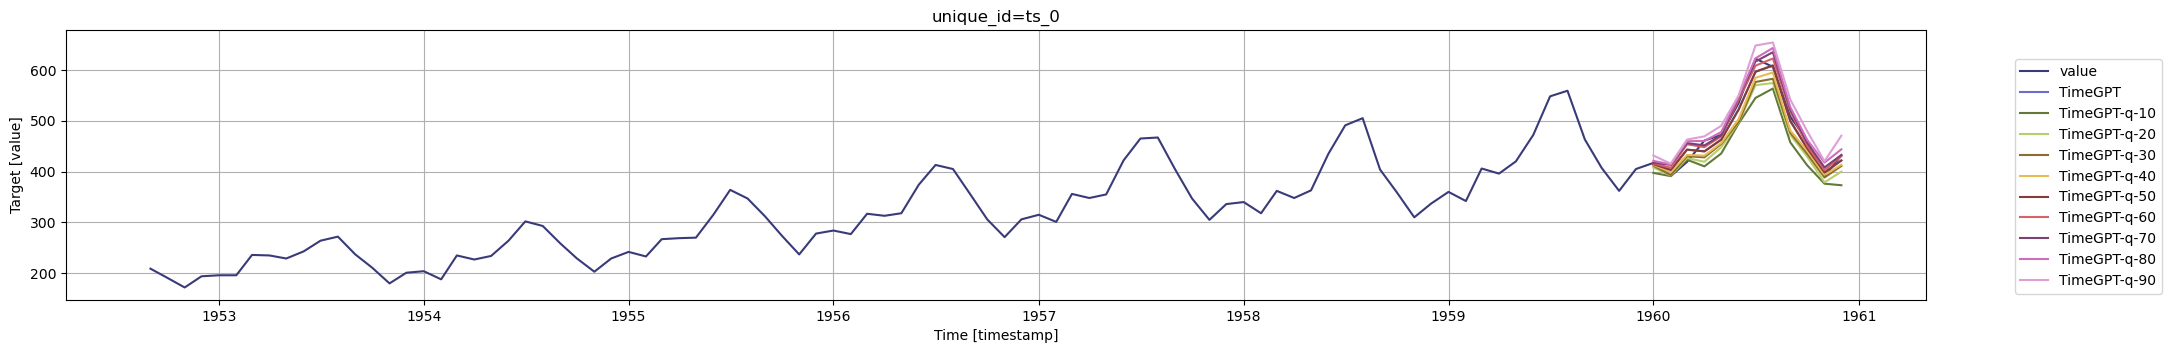

In [ ]:
cutoffs = timegpt_cv_quantile_fcst_df['cutoff'].unique()
for cutoff in cutoffs:
    fig = nixtla_client.plot(
        df.tail(100), 
        timegpt_cv_quantile_fcst_df.query('cutoff == @cutoff').drop(columns=['cutoff', 'value']),
        time_col='timestamp', 
        target_col='value'
    )
    display(fig)